# Solving LunarLander-v2 with Tabular, Deep-Q Network and Policy Gradient Methods (Policy Gradient section)
*  ## Group members:
   *  Mengyang Liu
   *  Xiaoyao Guo
   *  Yanan Wang

## Table of Content: <a class="anchor" id="TOC"></a>
* This table of content only works for offline.
* If this is opened on Colab, consider the generated table of content on the left.

<br>

### [Initialize and Setting up Environment](#ENV)
* [Initialization](#init)

<br>

### [REINFORCE](#REINFORCE)
* [Algorithm description and pseudo-code](#info)
* [Setting up and train](#train)

<br>

### [Results](#Result)
* [Visualization of the resulting model](#visual)

<br>

### [Conclusion](#conc)

## Initialize and Setting up Environment  <a class="anchor" id="ENV"></a>

<br>

*   [To Table of Contents](#TOC)

### Initialization <a class="anchor" id="init"></a>
*  TensorFlow is used as our deep learning library.
*  One custom packages are used:
   *  **"custom_animation.py"**: we only use method `animate_one_episode(env, policy)` to play one episode of LunarLander by the given policy and show the animation.
      *  Require `matplotlib` and `opencv-python`.

In [ ]:
%matplotlib notebook
import numpy as np
import gym
import tensorflow as tf

# Ignore deprecation warnings:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualization
from IPython.display import HTML
import matplotlib.pyplot as plt

# If running on Colab, we need to specify the path of this notebook
import sys
if "google.colab" in sys.modules:
    # Set this to the directory of this file in Google Drive
    notebook_path = '/content/drive/MyDrive/CISC 474/code' 
    sys.path.append(notebook_path)
    sys.path.append(notebook_path+'/models')
    sys.path.append(notebook_path+'/models/clips')
    from google.colab import files
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = notebook_path
else:
    root_path = '.'
    
# Custom package
import custom_animation as ani

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*  See if GPU is available

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


*   Run the following code if not on Colab for visualization.

In [ ]:
pip install opencv-python

*  Set up LunarLander-v2 environment.

In [ ]:
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)

*   A function to plot learning curves.

In [ ]:
def plot_learning_curve(epoch_lists, epoch_size = 100, legend = None, title = None, x_label = "episodes", y_label = "avg reward per epoch", size = 1):
    for i in range(len(epoch_lists)):
        x = [(j+1)*epoch_size for j in range(len(epoch_lists[i]))]
        if not legend:
            plt.plot(x, epoch_lists[i])
        else:
            plt.plot(x, epoch_lists[i], label = legend[i])
            
    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title("Learning curves for each training episode", fontsize=17)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.figure(figsize=[size*6.4, size*4.8])

*  **Allow displaying figures in Colab.**
   *  Run this after the animation for cleaner outputs.

In [ ]:
if "google.colab" in sys.modules:
  %matplotlib inline

## REINFORCE <a class="anchor" id="REINFORCE"></a>

<br>

*   [To Table of Contents](#TOC)

### Algorithm Description and Pseudo-code: <a class="anchor" id="info"></a>
*  Update with gradients, but in a Monte-Carlo manner. No need for experience replay.
*  Network outputs $\pi(S,A,\vec{w})$ instead of $Q_(S,A,\vec{w})$
  *  Add a $\mathrm{softmax}()$ layer.
*  Estimate is now $G_t$, so it is treated as contsant in SGD. No target network required.

<br>

*  Pseudo-code for REINFORCE algorithm:
  >  *  Initialize weights $\vec{w}$ arbitrarily
  >  *  Create an empty list $\text{Episode List}$
  >  *  Repeat:
  >     *  Generate an episode $(S_0,A_0,R_1,\dots,S_{T-1}, A_{T-1}, R_T)$ following $\pi(A|S,\vec{w})$
  >     *  Append this episode to $\text{Episode List}$
  >     *  For every $k$ episodes:
  >        *  For each episode in $\text{Episode List}$:
  >           *  $G_{T}\leftarrow0$
  >           *  For $t$ from $T-1$ to $1$:
  >              *  $G_t\leftarrow R_{t+1}+\gamma G_{t+1}$
  >        *  Standardize $G_t$ across all $k$ episodes in $\text{Episode List}$. 
  >        *  For each episode in $\text{Episode List}$:
  >           *  For $t$ from $1$ to $T-1$:
  >              *  $\vec{w}\leftarrow \vec{w}+\alpha\frac{\partial}{\partial \vec{w}}[\ln(\pi(A_t|S_t,\vec{w}))G_t]$
  >        *  $\text{Episode List}\leftarrow \text{Empty}$
*  Since we are using gradient descent, we rewrite the update rule into $\vec{w}\leftarrow \vec{w}-\alpha\frac{\partial}{\partial \vec{w}}[-\ln(\pi(A_t|S_t,\vec{w}))G_t]$
  *  Then pass $-\ln(\pi(A_t|S_t,\vec{w}))G_t$ into optimizer.

In [ ]:
class REINFORCE:

    def __init__(self, model, action_num, gamma = 0.99):
        self.action_num = action_num
        self.model = model

        # Discount factor
        self.gamma = gamma

        # Use a list of lists to store the (S_t,R_t+1) tuple of each episode
        self.epi_lists = []
    
    # Given the observation of the state, return the predicted action
    def predict(self, obs):
        return self.model.predict(obs[np.newaxis],verbose=0).argmax()

    # No Epsilon-greedy, use policy directly for exploration
    def epredict(self, obs):
        probs = self.model.predict(obs[np.newaxis],verbose=0)[0]
        # Use a more stable method than np.random.choice
        rand = np.random.uniform(0,1,1)
        for i in range(self.action_num):
            if rand <= probs[i]:
                return i
            else:
                rand -= probs[i]
        return self.action_num-1
  
    # Choose and execute an action, then add it to the replay buffer.
    def step(self, env, state):
        # Choose and execute an action
        action = self.epredict(state)
        next_state, reward, done, info = env.step(action)
        # return A_t, R_t+1, S_t+1, done, info
        return action, reward, next_state, done, info

    # Apply update rule at each timestep in the stored experiences
    def update(self, return_mat, optimizer):
        for i in range(len(self.epi_lists)):
            for t in range(len(self.epi_lists[i])):
        
                state, action, reward = self.epi_lists[i][t]

                # Use tf.GradientTape() to gain more low-level control over the update
                with tf.GradientTape() as tape:

                    # Calculate probability to choose A_t in S_t.
                    probs = self.model(state[np.newaxis])[0][action]

                    # Compute score
                    score = -1 * tf.math.log(probs) * return_mat[i][t]

                # Take gradient of score and update
                grads = tape.gradient(score, self.model.trainable_variables)
                optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    # Train with REINFORCE

    # optimizer: the optimization algorithm used for SGD
    # update_episodes: the number of episodes passed to update the weights once
    # epoch_size: number of episodes to report
    # max_episodes: training will stop if it is reached
    # max_steps: maximum numbers of timesteps allowed in each episodes.
    #       200 is selected to be specific to Lunarlander.
    # verbose: True to print report

    def train(self, env, optimizer, update_episodes = 4, epoch_size=20, max_episodes=200, max_steps=200, verbose=False):
        # Below for report
        episode_step_list = []
        episode_reward_list = []
        epoch_step = 0
        epoch_reward = 0
        episode_step = 0
        episode_reward = 0
        prev_reward = 0

        # To select the best model
        best_reward = 0
        best_weights = self.model.get_weights()

        # Start training
        for episode in range(max_episodes):
            # New episode begins
            state = env.reset()
            epi_list = []
            # Terminate this episode if max_steps is reached
            for time_step in range(max_steps):
                last_state = state
                action, reward, state, done, info = self.step(env, state)
                # Append (S_t, A_t, R_t+1) to the list of experience in the episode
                epi_list.append((last_state, action, reward))
                
                episode_reward += reward
                if done: break
            # 1 episode is finished            
            self.epi_lists.append(epi_list)

            # Update records
            episode_step = len(epi_list)
            epoch_step += episode_step
            epoch_reward += episode_reward
            
            episode_step_list.append(episode_step)
            episode_reward_list.append(episode_reward)
            episode_reward = 0
            
            # Update every some episodes
            if (episode+1) % update_episodes == 0:
                return_mat = []
                for exp_list in self.epi_lists:
                    # Calculate returns
                    return_list = np.zeros(len(exp_list))

                    # G_T-1 = R_T
                    return_list[len(exp_list)-1] = exp_list[len(exp_list)-1][2]
                    for t in range(len(exp_list)-2,-1,-1):
                        return_list[t] = exp_list[t][2] + self.gamma * return_list[t+1]
                        
                    
                    return_mat.append(return_list)
                    
                return_flat = np.concatenate(return_mat)
                
                # Standardize returns

                for i in range(len(return_mat)):
                    return_mat[i] = ((return_mat[i]- return_flat.mean()) / return_flat.std())
    
                # Update network
                self.update(return_mat, optimizer)
            
                self.epi_lists = []

            
                
            # See if best weights need to update
            if episode_reward >= best_reward:
                best_reward = episode_reward
                best_weights = self.model.get_weights()

            # 1 epoch is finished if the following is satisfied
            if ((episode+1)% epoch_size) == 0:
                epoch_step = epoch_step / epoch_size
                epoch_reward = epoch_reward / epoch_size
        
                if verbose:
                    print("episode: %d, avg episode steps: %.4f, avg episode reward: %.4f, abs reward diff: %.4f" 
                          % (episode+1, epoch_step, epoch_reward, abs(epoch_reward-prev_reward))) 
        
                prev_reward = epoch_reward
                epoch_step = 0
                epoch_reward = 0
    
        self.model.set_weights(best_weights)

        return episode_step_list, episode_reward_list

### Setting up and train <a class="anchor" id="train"></a>

In [ ]:
input_shape = env.observation_space.shape #[8]
action_num = env.action_space.n #4

policy_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(action_num, activation="softmax")
    # Softmax activation for outputting policies
])

In [ ]:
policy_grad = REINFORCE(policy_model, action_num, gamma=0.99)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

tf.debugging.set_log_device_placement(True)
episode_step_list, episode_reward_list = policy_grad.train(env=env, optimizer=optimizer, update_episodes = 4, epoch_size=200, max_episodes=4000, max_steps=200, verbose=True)

episode: 200, avg episode steps: 66.6100, avg episode reward: -552.2139, abs reward diff: 552.2139
episode: 400, avg episode steps: 66.7900, avg episode reward: -580.6539, abs reward diff: 28.4400
episode: 600, avg episode steps: 66.6250, avg episode reward: -568.5776, abs reward diff: 12.0763
episode: 800, avg episode steps: 66.9750, avg episode reward: -570.3597, abs reward diff: 1.7821
episode: 1000, avg episode steps: 66.8350, avg episode reward: -574.0340, abs reward diff: 3.6743
episode: 1200, avg episode steps: 65.1400, avg episode reward: -555.6281, abs reward diff: 18.4059
episode: 1400, avg episode steps: 65.6250, avg episode reward: -553.6869, abs reward diff: 1.9412
episode: 1600, avg episode steps: 67.6000, avg episode reward: -590.1908, abs reward diff: 36.5039
episode: 1800, avg episode steps: 67.2450, avg episode reward: -586.2311, abs reward diff: 3.9597
episode: 2000, avg episode steps: 66.8350, avg episode reward: -571.3636, abs reward diff: 14.8675
episode: 2200, av

<IPython.core.display.Javascript object>


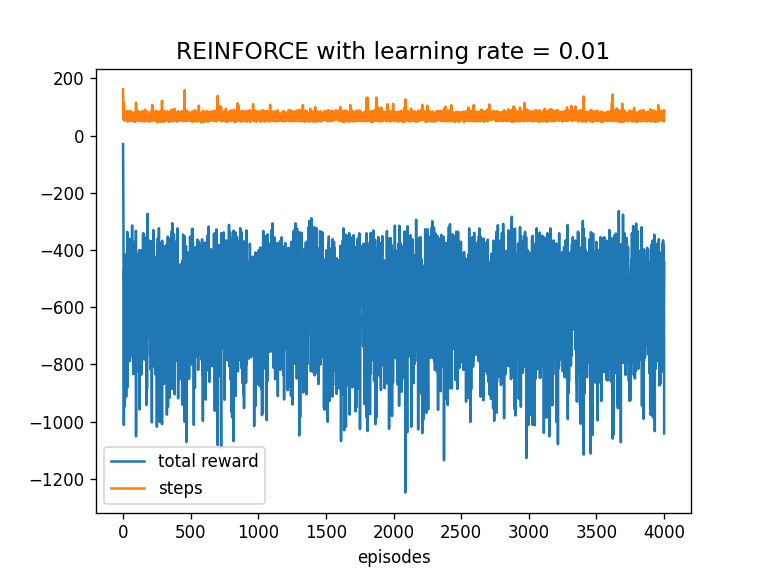

<IPython.core.display.Javascript object>


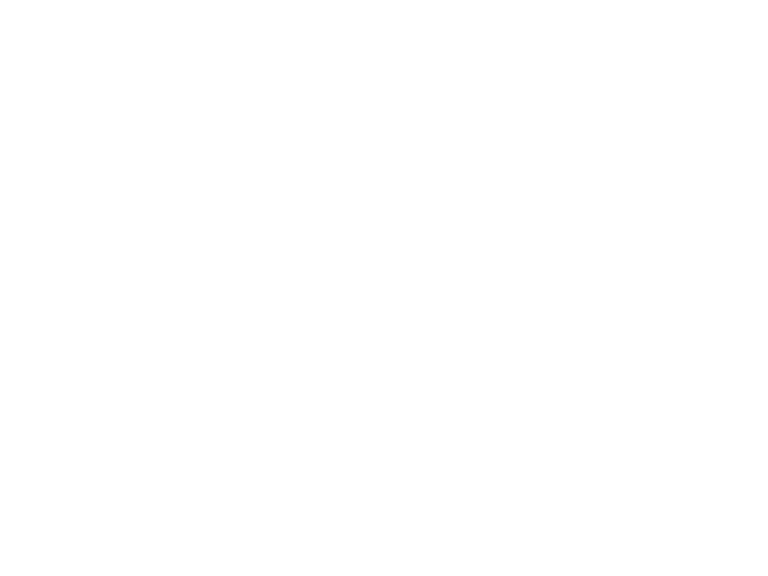

In [ ]:
plot_learning_curve([episode_reward_list, episode_step_list], epoch_size = 1, legend = ["total reward", "steps"], title = "REINFORCE with learning rate = 0.01", x_label = "episodes", y_label = "", size = 1)

In [ ]:
policy_grad.model.save("./REINFORCE.h5")

## Results <a class="anchor" id="Result"></a>

<br>

*   [To Table of Contents](#TOC)

### Visualization of the resulting model <a class="anchor" id="visual"></a>

In [ ]:
class Demo:
    def __init__(self, model):
        self.model = model
    def predict(self, obs):
        return self.model.predict(obs[np.newaxis],verbose=0)[0].argmax()

In [ ]:
reinforce = Demo(tf.keras.models.load_model(root_path+'/models/REINFORCE.h5'))
anim = ani.animate_one_episode(env, reinforce)
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

## Conclusion <a class="anchor" id="conc"></a>

<br>

*   [To Table of Contents](#TOC)